In [1]:
!pip install \
    numpy \
    pandas \
    sklearn \
    matplotlib \
    openpyxl \
    tensorflow \
    tensorflow_hub \
    nltk

In [2]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
# read in data
raw_data = pd.read_excel('purchase_orders_final.xlsx')

In [4]:
# remove contracts with the same name
# to avoid data leakage between training and validation data
# which would lead to inflated accuracy scores
raw_data = raw_data.drop_duplicates(subset=['CONTRACT_NAME'])

In [5]:
data = pd.DataFrame()

# create a single combined feature based on the three fields with most obvious predictive power
data['feature'] = raw_data['CONTRACT_NAME'].astype(str) + ' ' + \
                  raw_data['EXTENDED_DESCRIPTION'].astype(str) + ' ' + \
                  raw_data['VENDOR_NAME'].astype(str)
# ignoring other fields for now because a simpler model is more easily trained, retrained, and explained
# and there is no point making a more complicated model when a simpler one will be sufficient

In [6]:
# clean and prep the feature data
# << TODO: investigate relevance of digits or punctuation for further iterations >>

# - remove digits
data['feature'] = data['feature'].str.replace(r'\d+', ' ', regex=True)

# - remove punctuation
data['feature'] = data['feature'].str.replace(r'[^\w\s]+', ' ', regex=True)

# - remove repeated whitespace
data['feature'] = data['feature'].str.replace(r'\s+', ' ', regex=True)

# - convert to lowercase
data['feature'] = data['feature'].str.lower()

print(data['feature'])

0        critical materials supply arrangement transfor...
1        forecasted jobs transformer pad mounted phase ...
2        apac texas hot mix various sections nan apac t...
3                           apac hotmix nan apac texas inc
7        tessco do request see attached thick mount rg ...
                               ...                        
28414    evs quote buyboard pricing_ evs quote buyboard...
28418    bsd october purchase of trash cans nan w w gra...
28420    lowe s concrete crew brad kirk saws and locks ...
28423    grainger chipping hammer blades uer guerrero n...
28428    insight quote u s communities insight quote mr...
Name: feature, Length: 6551, dtype: object


In [7]:
# remove english stop words which will contain little predictive power
# and will distract from the more important vocabulary within the feature

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

def remove_stopwords(sentence):
    return " ".join([word
                     for word in sentence.split(" ")
                     if word not in stop])

data['feature'] = data['feature'].apply(remove_stopwords)

print(data['feature'])

0        critical materials supply arrangement transfor...
1        forecasted jobs transformer pad mounted phase ...
2        apac texas hot mix various sections nan apac t...
3                           apac hotmix nan apac texas inc
7        tessco request see attached thick mount rg u d...
                               ...                        
28414    evs quote buyboard pricing_ evs quote buyboard...
28418    bsd october purchase trash cans nan w w graing...
28420    lowe concrete crew brad kirk saws locks nan lo...
28423    grainger chipping hammer blades uer guerrero n...
28428    insight quote u communities insight quote mr h...
Name: feature, Length: 6551, dtype: object


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# inspect the number of labels (codes)
codes = raw_data[['COMMODITY_CODE', 'COMMODITY_DESCRIPTION']].drop_duplicates()
print(codes)

    COMMODITY_CODE                              COMMODITY_DESCRIPTION
0            28586  Transformers, Power Distribution (Incl. Fluid ...
2          7452114  ASPHALTIC CONCRETE, HOT MIX, IN ACCORDANCE WIT...
7            72582     Two-Way Radio Supplies, Parts, and Accessories
8            20464  Network Components: Adapter Cards, Bridges, Co...
9            28574  Pole Line Hardware: Anchors, Arms, Bolts, Braces,
14           80072                                  Shoes, Safety Toe
22           20811                Application Software, Microcomputer
24           54523      Impact Tools, Air Powered (Not Road Building)
27         7450841                                 EMULSIONS, ASPHALT
39          555444                                  LIGHTS, EMERGENCY


In [9]:
# the comodity codes are simply IDs, for the purpose of simpler model training use one hot encoding
onehot = pd.get_dummies(raw_data['COMMODITY_CODE'])

print(onehot)

       20464    20811    28574    28586    54523    72582    80072    555444   \
0            0        0        0        1        0        0        0        0   
1            0        0        0        1        0        0        0        0   
2            0        0        0        0        0        0        0        0   
3            0        0        0        0        0        0        0        0   
7            0        0        0        0        0        1        0        0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
28414        0        0        0        0        0        0        0        1   
28418        0        0        0        0        1        0        0        0   
28420        0        0        0        0        1        0        0        0   
28423        0        0        0        0        1        0        0        0   
28428        1        0        0        0        0        0        0        0   

       7450841  7452114  
0

In [10]:
# combine feature and labels into a single dataframe
data = data['feature'].to_frame()

data = data.join(onehot)

print(data)

                                                 feature  20464  20811  28574  \
0      critical materials supply arrangement transfor...      0      0      0   
1      forecasted jobs transformer pad mounted phase ...      0      0      0   
2      apac texas hot mix various sections nan apac t...      0      0      0   
3                         apac hotmix nan apac texas inc      0      0      0   
7      tessco request see attached thick mount rg u d...      0      0      0   
...                                                  ...    ...    ...    ...   
28414  evs quote buyboard pricing_ evs quote buyboard...      0      0      0   
28418  bsd october purchase trash cans nan w w graing...      0      0      0   
28420  lowe concrete crew brad kirk saws locks nan lo...      0      0      0   
28423  grainger chipping hammer blades uer guerrero n...      0      0      0   
28428  insight quote u communities insight quote mr h...      1      0      0   

       28586  54523  72582 

In [11]:
# split data into train and test samples
train, test = train_test_split(data, test_size=0.2)


# split data into input and label
labels = codes['COMMODITY_CODE'].tolist()

train_input = train['feature']
train_labels = train[labels]

test_input = test['feature']
test_labels = test[labels]

In [12]:
# check whether GPU is avaliable
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is NOT AVAILABLE


In [13]:
# download text embedding layer from TensorFlow hub
# << TODO: investigate performance using other avliable embedding layers >>
# << TODO: investigate extending embedding to perform better with less specific vocabulary in data >>
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

# output two sample feature embeddings
print(hub_layer(train_input[:2]))

tf.Tensor(
[[ 1.51969910e-01 -4.78181720e-01  1.81270421e-01  1.14537030e-01
   8.38414580e-02 -2.26636291e-01 -1.64637491e-01  1.27808332e-01
  -2.76902854e-01 -2.20828503e-01 -5.42066768e-02  3.68506551e-01
   3.42955470e-01 -5.81438653e-02 -2.51197040e-01 -5.83116636e-02
   3.78715605e-01  1.63032025e-01  3.33937965e-02 -1.82106465e-01
  -7.32157528e-02 -8.10966641e-02  2.11484477e-01 -9.39105973e-02
  -3.08622178e-02 -1.71317272e-02  1.85281545e-01  1.81035727e-01
  -1.60581376e-02 -1.30918860e-01  1.88055262e-01 -3.45804036e-01
  -3.21992010e-01 -1.80089206e-01 -1.14186406e-02 -2.23952532e-01
   7.19299316e-02 -2.68653423e-01  1.28609136e-01 -2.41064310e-01
   1.08152535e-02 -1.26258194e-01  1.28682237e-02 -4.08498868e-02
  -1.29366204e-01  6.34286106e-02 -5.90109676e-02  1.85215622e-01
  -5.83765423e-03  1.65311545e-01]
 [-2.30611160e-01 -2.56147623e-01 -2.52227247e-01 -5.00734784e-02
   1.05996162e-01  8.41839239e-02  2.17133865e-01 -2.77580228e-03
  -1.28311202e-01 -3.92495841e

In [14]:
# build simple two layer sequential Keras model using
# - text embedding layer
# - simple dense layer outputing to a node for each commodity code
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(len(labels), activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 48,191,110
Trainable params: 48,191,110
Non-trainable params: 0
_________________________________________________________________


In [15]:
# compile model with choice of standard optimizer and loss functions
# << TODO: investigate performance using different optimizer and loss functions >>

model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [16]:
EPOCHS = 20

# train the model
# fit the model to the training data using the Keras method .fit()
history = model.fit(train_input,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=256,
                    shuffle=True,
                    validation_split=0.8,
                    verbose=1)

Epoch 1/20
5/5 [==============================] - 3s 607ms/step - loss: 0.7619 - accuracy: 0.4702 - val_loss: 0.7463 - val_accuracy: 0.5197
Epoch 2/20
5/5 [==============================] - 3s 515ms/step - loss: 0.7413 - accuracy: 0.5447 - val_loss: 0.7304 - val_accuracy: 0.5818
Epoch 3/20
5/5 [==============================] - 2s 504ms/step - loss: 0.7254 - accuracy: 0.6061 - val_loss: 0.7181 - val_accuracy: 0.6498
Epoch 4/20
5/5 [==============================] - 3s 508ms/step - loss: 0.7131 - accuracy: 0.6846 - val_loss: 0.7092 - val_accuracy: 0.7072
Epoch 5/20
5/5 [==============================] - 3s 522ms/step - loss: 0.7045 - accuracy: 0.7475 - val_loss: 0.7031 - val_accuracy: 0.7563
Epoch 6/20
5/5 [==============================] - 3s 511ms/step - loss: 0.6991 - accuracy: 0.8013 - val_loss: 0.6991 - val_accuracy: 0.7953
Epoch 7/20
5/5 [==============================] - 3s 510ms/step - loss: 0.6956 - accuracy: 0.8425 - val_loss: 0.6965 - val_accuracy: 0.8290
Epoch 8/20
5/5 [====

In [17]:
# compute results on test data

test_loss, test_accuracy = model.evaluate(test_input, test_labels)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

41/41 [==============================] - 0s 1ms/step - loss: 0.6811 - accuracy: 0.8953
Test Loss:  0.6810747385025024
Test Accuracy:  0.895270824432373


In [49]:
# investigate predictions on specific examples

eg = 10

example = test_input.iloc[eg]
print("Example input feature (combined contract name, description and vendor: \n", example)

prediction = model.predict([example])

print("\nPrediction: ")
for code_desc, pred in zip(codes["COMMODITY_CODE"].tolist(), prediction[0]):
    print(f"{code_desc:8}", f"{pred:.4f}")

print("\nAnswer: ")
print(test_labels.iloc[eg])

Example input feature (combined contract name, description and vendor: 
 red wing velazquez jose red wing velazquez jose red wing shoe store

Prediction: 
   28586 0.0000
 7452114 0.0000
   72582 0.0048
   20464 0.0000
   28574 0.0000
   80072 0.2805
   20811 0.0000
   54523 0.0000
 7450841 0.0000
  555444 0.0000

Answer: 
28586      0
7452114    0
72582      0
20464      0
28574      0
80072      1
20811      0
54523      0
7450841    0
555444     0
Name: 4948, dtype: uint8


In [50]:
# extract accuracy and loss data across epochs of training from model history object

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(EPOCHS)

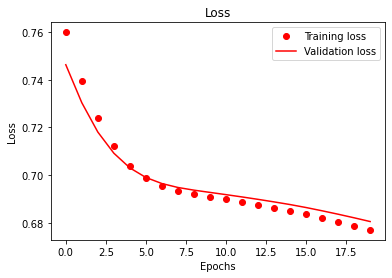

In [51]:
# plot loss against epochs of training

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

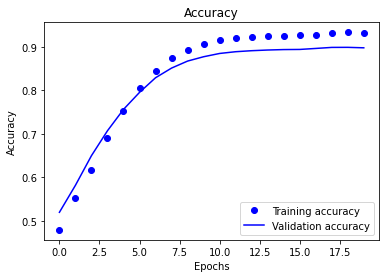

In [52]:
# plot model accuracy against epochs of training

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()